In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#Data Preprocessing

In [ ]:
# Model/data parameters
num_classes = 10
input_shape = (28,28,1)

# load the data and divide it into train/test split
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images into the [0 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images with size (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


#Model

Rete è composta dai seguenti layers.

|Input|Tipo Layer|Output|N.Parameters|
|-----|----------|------|------------|
|28x28x1|Conv1: 3x3x1x16|26x26x16|(3x3x1x16) + 16 = 160|
| | | | |
|26x26x16|Pool1: max(2,2)|13x13x16|0|
| | | | |
|13x13x16|Conv2: 3x3x16x16|11x11x16|(3x3x16x16) + 16 = 2320|
| | | | |
|11x11x16|Pool2: max(2,2)|5x5x16|0|
| | | | |
|5x5x16|Flatten|1x400|0|
| | | | |
|1x400|Dense|1x10|(400x10) + 10 = 410| 
| | | | |
| | | | Totale = 160 + 2320 + 410 = 6490|

Sono presenti due livelli di convoluzione con filtri di dimensione 3x3, questi livelli hanno depth 16 (numero di filtri applicati). 
Ogni livello convoluzionale è seguito da un livello di spacial pooling, in questo caso max pooling, di dimensione 2x2.

L'output di questi 4 livelli è trasformato in un vettore "flatten" di dimensione 1x400. 

Questo vettore diventerà input dell'ultimo layer dense che unisce al layer di output composto da 10 neuroni (numero di classi da predire).

E' stato introdotto anche un layer di dropout, in modo da aumentare la regularization e diminuire la possibilità di overfitting. 
 


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4

#Training model

Batch size utilizata è 128.\
Funzione di loss usata è categorical_crossentropy, utile per problemi di classificazione multi-classe. (in questo caso 10 classi da predire) \
Optimizer usato è adam, il valore di default di learning rate in questo caso è 0.001. E' stato provato anche SGD ma vi è stato un leggero decremento delle performance rispetto a quelle ottenute con adam. SGD è risultato più veloce in fase di training del modello.\
Metrica usata è accuracy, fornisce accuratezza del modello.\
Numero di epochs è 15, è stato aggiunto la callback di EarlyStopping in fase di training in modo da bloccare l'addestramento dopo 5 epochs senza miglioramenti della accuracy sul validation set. Questo è stato fatto per aumentare la generalizzazione del modello e ridurre l'overfitting. 

X_train di partenza è stato partizionato, attraverso l'operazione validation_split, in due ulteriori dataset, training set e validation set. 

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.25,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=5)])

Epoch 1/15
352/352 [==============================] - 18s 51ms/step - loss: 0.0896 - accuracy: 0.9726 - val_loss: 0.0489 - val_accuracy: 0.9855
Epoch 2/15
352/352 [==============================] - 18s 50ms/step - loss: 0.0865 - accuracy: 0.9726 - val_loss: 0.0483 - val_accuracy: 0.9851
Epoch 3/15
352/352 [==============================] - 18s 51ms/step - loss: 0.0881 - accuracy: 0.9730 - val_loss: 0.0517 - val_accuracy: 0.9837
Epoch 4/15
352/352 [==============================] - 18s 51ms/step - loss: 0.0872 - accuracy: 0.9733 - val_loss: 0.0478 - val_accuracy: 0.9858
Epoch 5/15
352/352 [==============================] - 18s 51ms/step - loss: 0.0815 - accuracy: 0.9748 - val_loss: 0.0472 - val_accuracy: 0.9855
Epoch 6/15
352/352 [==============================] - 18s 51ms/step - loss: 0.0839 - accuracy: 0.9747 - val_loss: 0.0455 - val_accuracy: 0.9859
Epoch 7/15
352/352 [==============================] - 18s 51ms/step - loss: 0.0821 - accuracy: 0.9748 - val_loss: 0.0463 - val_accuracy:

I risultati durante la fase di training sono molto alti. Sopra il 97% di accuracy sia per il training set che per il validation set. \
Nonostante il numero di filtri utilizzati (16), sia relativamente basso rispetto agli standard, sono state ottenute buone performance. Questo è sicuramente legato alla semplicità del dataset.

#Plot Accuracy & Loss

Sono stati plottati i risultati di loss e di accuracy per il modello.\
Nel primo grafico si può vedere come vi è un costante incremento dell'accuracy.\
Mentre nel secondo vi è un costante diminuzione del valore di loss function. 

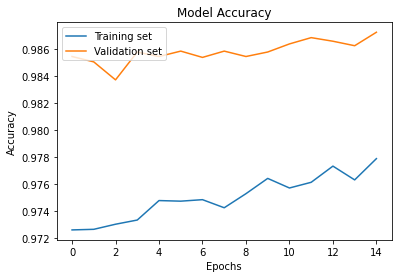

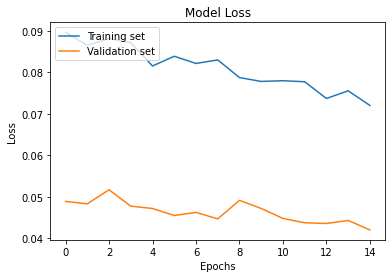

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

#Evaluate model

La predizione sul test set (insieme di immagini mai viste dal classificatore) è molto alto, più del 98% di accuracy.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03334539011120796
Test accuracy: 0.9887999892234802
